# **Yelp Data Predictive Modeling**

Joseph Lardie

December 2023

# **Objective:**

- Predicting the ratings for Brooklyn Pizza Restaurants on YELP

# **Imports**

In [1]:
#Numpy
import numpy as np

#Pandas
import pandas as pd

#Seaborn
import seaborn as sns

#matplotlib
import matplotlib.pyplot as plt
import plotly
%matplotlib inline

# Standard imports
import re

#sklearn
from sklearn import preprocessing
from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# warnings
import warnings
warnings.filterwarnings("ignore")
set_config(display = 'diagram')

# **Loading Data**

In [2]:
# Loading YELP Review Data
ydf = pd.read_csv('ydf')

In [3]:
# Glance of YELP Data
ydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   alias         847 non-null    object 
 1   name          847 non-null    object 
 2   image_url     847 non-null    object 
 3   url           847 non-null    object 
 4   review_count  847 non-null    int64  
 5   categories    847 non-null    object 
 6   rating        847 non-null    float64
 7   coordinates   847 non-null    object 
 8   transactions  847 non-null    object 
 9   location      847 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 66.3+ KB


# **Data Cleaning**

In [4]:
# Dropping irrelevant 
ydf.drop(['image_url', 'url'], axis=1, inplace=True)

# **Visualizations**

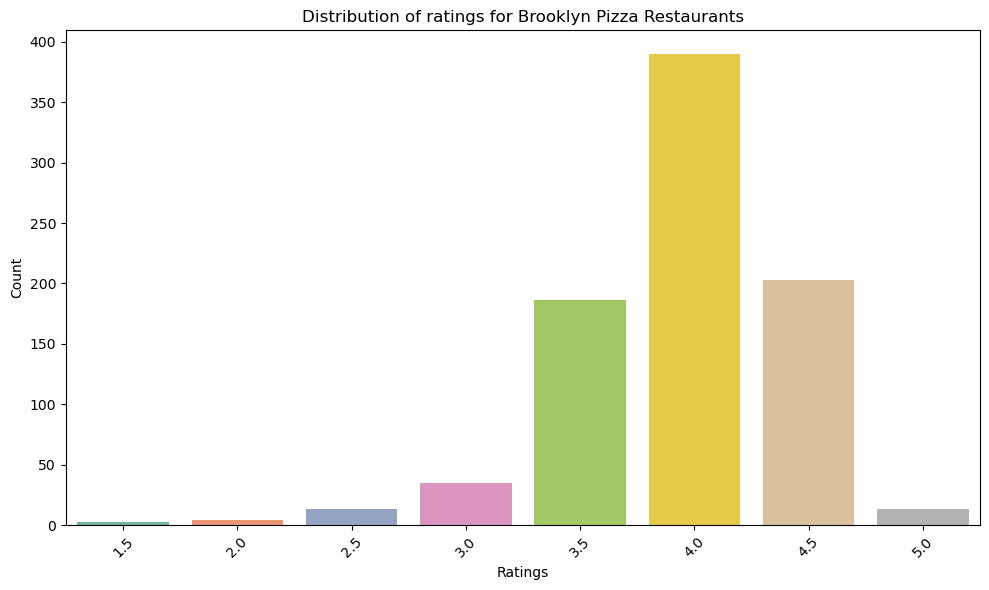

In [5]:
# Visualizing Distribution of Restaurants in NYC Boroughs
plt.figure(figsize=(10, 6))
sns.countplot(data=ydf, x='rating', palette='Set2') 
plt.title('Distribution of ratings for Brooklyn Pizza Restaurants')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

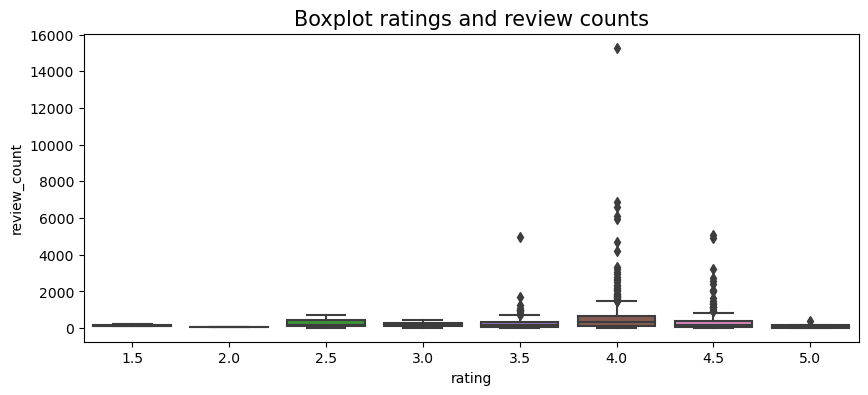

In [10]:
# Create a boxplot using Seaborn
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
sns.boxplot(x='rating', y='review_count', data=ydf)
plt.title('Boxplot ratings and review counts', fontsize=15)

# Show the plot
plt.show()

# **Validation Split**

In [ ]:
# Defining the target variable
X= ydf.drop('rating', axis=1)
y= ydf['rating']

# **Data Preprocessing**

In [ ]:
# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Check for missing values
print("Missing values in X_train:", X_train.isnull().sum().sum())
print("Missing values in y_train:", y_train.isnull().sum().sum())

# Check data types
print("Data types in X_train:\n", X_train.dtypes)
print("Data type in y_train:", y_train.dtypes)

In [ ]:
#Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy= 'mean')

# Standard Scaler
scaler = StandardScaler()

# OneHotEncoder
ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')

# Instantiate the selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

# Forming pipelines
num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

#Create Tuples
num_tuple = ('num', num_pipe, num_selector)
cat_tuple = ('cat', cat_pipe, cat_selector)

#Make tuples for preprocessing the categorical and numeric columns
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)  

#Create Column Transformer
preprocessor= make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')

In [ ]:
# Looking at how the preprocessor is organized
preprocessor

# **Linear Regression**

In [ ]:
# Create the final pipeline with the preprocessor and the linear regression model
lr_model = make_pipeline(preprocessor, LinearRegression())

In [ ]:
# Train the model
lr_model.fit(X_train, y_train)

In [ ]:
# Make predictions on the training set
y_train_pred = lr_model.predict(X_train)

# Make predictions on the test set
y_test_pred = lr_model.predict(X_test)

In [ ]:
# Evaluate the model
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

In [ ]:
# Mean Squared Error
mse_lr = mean_squared_error(y_test, y_test_pred)
print(f'Mean Squared Error (Linear Regression): {mse_lr:.2f}')

# **KNN Model**

In [ ]:
# Create the k-Nearest Neighbors model
knn_model = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors (n_neighbors) as needed

# Create the final pipeline with the preprocessor and the k-Nearest Neighbors model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('knn', knn_model)])

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate on Test Set
# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)